### Group 4
- Tristan van Weeren, 13998706
- Luuk van Steenoven, 13996983
- Maarten Hoogeboom, 14000369
- Roel Lust, 13985736

https://github.com/MaartenH327/groupassignment-AppliedAI

In [1]:
print("Hello world")

Hello world


In [2]:
import os
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

Load the datasets

In [3]:
# Load CSV files
train_df = pd.read_csv("data/semart_train.csv", sep="\t", encoding="ISO-8859-1")
test_df = pd.read_csv("data/semart_test.csv", sep="\t", encoding="ISO-8859-1")
val_df = pd.read_csv("data/semart_val.csv", sep="\t", encoding="ISO-8859-1")

In [4]:
train_df.columns

Index(['IMAGE_FILE', 'DESCRIPTION', 'AUTHOR', 'TITLE', 'TECHNIQUE', 'DATE',
       'TYPE', 'SCHOOL', 'TIMEFRAME'],
      dtype='object')

From data visualisation and interpretation it's clear that most of the dataset is from 1400 onwards, and the pictures are mostly 5 classes. For the rest of the report we will only focus on these categories in predicting.

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_3696\2739923199.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=type_counts.index, y=type_counts.values, palette="viridis")


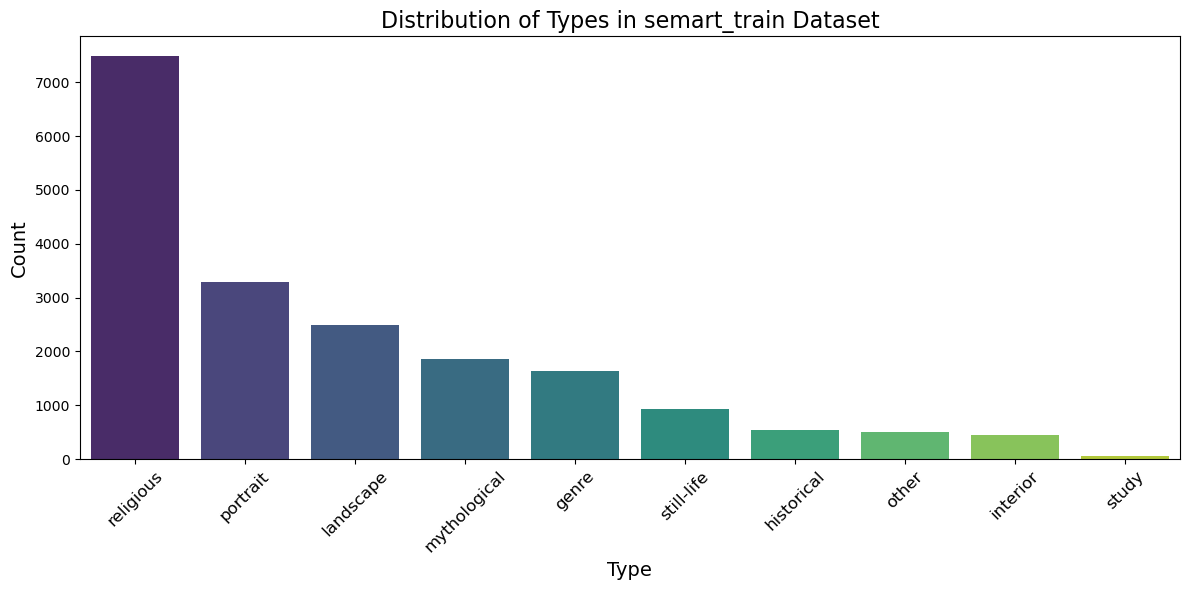

In [5]:
# Get value counts for the 'TYPE' column
type_counts = train_df["TYPE"].value_counts()

# Create a histogram plot
plt.figure(figsize=(12, 6))
sns.barplot(x=type_counts.index, y=type_counts.values, palette="viridis")

# Customize the plot
plt.title("Distribution of Types in semart_train Dataset", fontsize=16)
plt.xlabel("Type", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45, fontsize=12)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_3696\2287752424.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=timeframe_counts.index, y=timeframe_counts.values, palette="viridis")


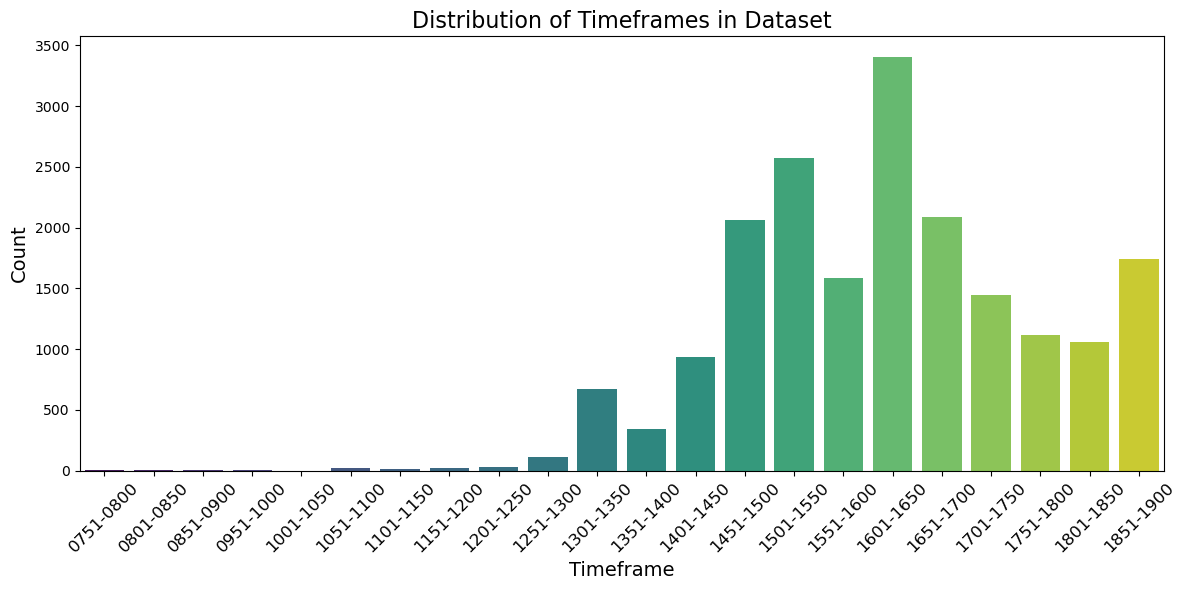

In [6]:
# Get value counts for the 'TIMEFRAME' column
timeframe_counts = train_df["TIMEFRAME"].value_counts()

# Sort the index sequentially (assuming numeric or sortable order)
timeframe_counts = timeframe_counts.sort_index()

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=timeframe_counts.index, y=timeframe_counts.values, palette="viridis")

# Customize the plot
plt.title("Distribution of Timeframes in Dataset", fontsize=16)
plt.xlabel("Timeframe", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45, fontsize=12)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

In [7]:
def filter_by_start_year(df, start_year=1401):
    """
    Filters a dataframe to include rows where the "TIMEFRAME" column 
    starts from a given year or later.

    Parameters:
        df (pd.DataFrame): The input dataframe.
        start_year (int): The minimum start year for filtering (default is 1401).

    Returns:
        pd.DataFrame: A filtered dataframe.
    """
    # Extract the start year from the TIMEFRAME column
    df["START_YEAR"] = df["TIMEFRAME"].str.split('-').str[0].astype(int)

    # Filter the dataframe based on the start year
    filtered_df = df[df["START_YEAR"] >= start_year]

    # Drop the START_YEAR column (optional)
    filtered_df = filtered_df.drop(columns=["START_YEAR"])

    return filtered_df


train_df = filter_by_start_year(train_df, start_year=1401)
val_df = filter_by_start_year(val_df, start_year=1401)
test_df = filter_by_start_year(test_df, start_year=1401)



In [8]:
len(train_df)

18006

In [9]:
len(val_df)

997

In [10]:
len(test_df)

1005

### Implement CNN Model of VG166!

We use VG166 because it's a pre-trained convolutional neural network (CNN) model known for its accuracy and simplicity. It has been trained on the ImageNet dataset to classify images into 1,000 categories.

The model works the following:

* Feature Extraction:
The VGG16 layers extract high-level features like edges, textures, and patterns from the input images.

* Custom Classification Head:
The added layers (Dense, Dropout, etc.) learn to map these features to specific classes in the dataset.

* Training:
The model optimizes its parameters to minimize the loss, adapting the Dense layers to the new task while keeping VGG16’s layers fixed.

* Evaluation:
The trained model is tested on new data to measure its ability to generalize.

* Prediction:
The final model predicts the class for new input images, providing a probabilistic output for each possible category.

In [11]:
#Thank god if you can use cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


#### With data augumentation

In [12]:
# Define transforms: Resize, Normalize and Convert to Tensor
transform = transforms.Compose([
    # Rotation
    transforms.RandomAffine(degrees=20),  
    
    # Width and height shift
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),  
    
    # Approximation of perspective transformations
    transforms.RandomAffine(degrees=0, shear=20),  
    
    # Zoom
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),  
    
    # Horizontal flip
    transforms.RandomHorizontalFlip(p=0.5),  
    
    transforms.ToTensor(),
    # Convert to tensor and normalize using ImageNet stats (So where the model was trained on)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

In [13]:
#This is torch.utils.data stuff
class SemArtDataset(Dataset):
    def __init__(self, dataframe, base_path, transform=None):
        self.dataframe = dataframe
        self.base_path = base_path
        self.transform = transform
        self.image_files = dataframe['IMAGE_FILE'].values
        self.labels = dataframe['TYPE'].values
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.base_path, img_name)
        image = Image.open(img_path)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


### Preparing the dateset

In [14]:
# Hard-code the classes to focus on: 'religious', 'portrait', 'landscape',"still-life","mythological"
target_classes = ['religious', 'portrait', 'landscape',"still-life","mythological"]

# Filter the DataFrames to include only these three classes
train_df = train_df[train_df['TYPE'].isin(target_classes)]
val_df = val_df[val_df['TYPE'].isin(target_classes)]
test_df = test_df[test_df['TYPE'].isin(target_classes)]

original_class_labels = train_df['TYPE'].unique()

# Reduce dataset size, if you need to testing something quick.
shrinkage = 1
train_df = train_df.head(len(train_df) // shrinkage)
test_df = test_df.head(len(test_df) // shrinkage)
val_df = val_df.head(len(val_df) // shrinkage)

# Label encoding
le = LabelEncoder()
train_df['TYPE'] = le.fit_transform(train_df['TYPE'])
test_df['TYPE'] = le.transform(test_df['TYPE'])
val_df['TYPE'] = le.transform(val_df['TYPE'])

encoded_to_original = dict(zip(range(len(le.classes_)), le.classes_))

# Load dataset
base_path = 'processed_imagesV2/'
train_dataset = SemArtDataset(train_df, base_path, transform=transform)
val_dataset = SemArtDataset(val_df, base_path, transform=transform)
test_dataset = SemArtDataset(test_df, base_path, transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
def trainmodel(train_loader, val_loader, learning_rate=1e-4, amount_of_nodes=256):
    """
    (...)

    Args:
        train_loader: Training dataset loader 
        val_loader: Validation dataset loader 
        amount_of_nodes: Number of nodes at the end default 256.
        learning_rate: Learning rate for the optimizer.

    """
    # Load the pre-trained VGG16 model
    model = models.vgg16(pretrained=True)

    # Freeze the convolutional base
    for param in model.features.parameters():
        param.requires_grad = False

    num_classes = len(np.unique(train_df['TYPE']))  # Number of classes in the dataset

    # Define the new classifier
    new_classifier = nn.Sequential(
        nn.Linear(25088, amount_of_nodes),  # First fully connected layer
        nn.ReLU(inplace=True),  # Activation function
        nn.Dropout(p=0.5),      # Dropout layer
        nn.Linear(amount_of_nodes, amount_of_nodes),  # Second fully connected layer
        nn.ReLU(inplace=True),  # Activation function
        nn.Dropout(p=0.5),      # Dropout layer
        nn.Linear(amount_of_nodes, num_classes)   # Output layer (for 1000 classes, modify if needed)
    )

    # Replace the original classifier
    model.classifier = new_classifier

    # Move model to device (GPU or CPU)
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate) 

    #Custom unique name so to keep track of trained models
    naam = f"{datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")}_BestModel_WithAugment{amount_of_nodes}_EndGame"

    # Training Loop with Tracking
    num_epochs = 10
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_validation_acc = -np.inf

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        
        # Wrap the train_loader with tqdm for progress bar
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", unit="batch") as progress_bar:
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device).long()  # Cast labels to torch.long

                # Zero the gradients
                optimizer.zero_grad()
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                # Track loss and accuracy
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)
                
                # Update the progress bar description
                progress_bar.set_postfix(loss=running_loss / (progress_bar.n + 1), accuracy=correct_preds / total_preds)
        
        # Calculate training loss and accuracy
        train_epoch_loss = running_loss / len(train_loader)
        train_epoch_accuracy = correct_preds / total_preds
        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_epoch_loss:.4f}, Training Accuracy: {train_epoch_accuracy:.4f}")
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct_preds = 0
        val_total_preds = 0

        with torch.no_grad():
            with tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", unit="batch") as val_bar:
                for inputs, labels in val_bar:
                    inputs, labels = inputs.to(device), labels.to(device).long()

                    # Forward pass
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # Track loss and accuracy
                    val_running_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    val_correct_preds += (predicted == labels).sum().item()
                    val_total_preds += labels.size(0)

                    # Update validation progress bar
                    val_bar.set_postfix(loss=val_running_loss / (val_bar.n + 1), accuracy=val_correct_preds / val_total_preds)

        # Calculate validation loss and accuracy
        val_epoch_loss = val_running_loss / len(val_loader)
        val_epoch_accuracy = val_correct_preds / val_total_preds
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)


        #hoogste opslaan Doe accuracy
        if val_epoch_accuracy>best_validation_acc:
            print("new best model")
            best_validation_acc = val_epoch_accuracy
            torch.save(model, f'trainedmodels\\{naam}.pth')



        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}")

    # Plot training and validation loss/accuracy
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
    plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
    plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.tight_layout()

    plt.savefig(f"trainedmodels\\{naam}.png", dpi=300)

    plt.show()

In [16]:
# If you don't have GPU it is going to take a really long time
#RTX 3050 ~30min for 10 epochs

#trainmodel(train_loader,val_loader)

## Testing custom images (the fun part)

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_3696\2276236934.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('trainedmodels\\2025_01_15_18_31_Best

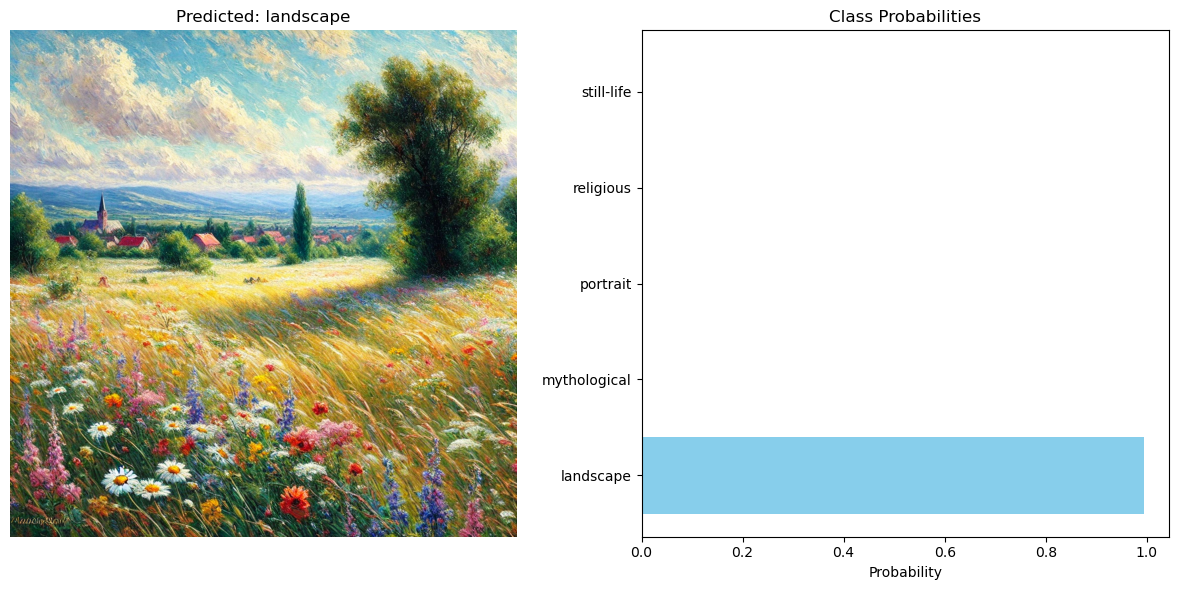

Predicted class: landscape


In [17]:
# Define the transformation pipeline (same as used in training)
transform_pipeline = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.CenterCrop((224, 224)),  # Resize the image to match input size
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Define the original class labels as per the encoding
original_class_labels = encoded_to_original

# Function to upload image, preprocess, and predict
def predict_image_with_probabilities(image_path, model, device):
    # Open the image
    image = Image.open(image_path).convert("RGB")  # Ensure it is RGB

    # Apply transformations
    image_tensor = transform_pipeline(image).unsqueeze(0)  # Add batch dimension

    # Move the image tensor to the device
    image_tensor = image_tensor.to(device)

    # Set model to evaluation mode
    model.eval()

    with torch.no_grad():
        # Pass the image through the model
        outputs = model(image_tensor)
        
        # Apply softmax to get probabilities
        probabilities = F.softmax(outputs, dim=1).cpu().numpy().squeeze()

    # Get the predicted label
    predicted_index = torch.argmax(outputs, dim=1).item()
    predicted_class = original_class_labels[predicted_index]

    # Plot the image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis("off")

    # Plot the probabilities
    plt.subplot(1, 2, 2)
    classes = [original_class_labels[i] for i in range(len(probabilities))]
    plt.barh(classes, probabilities, color="skyblue")
    plt.xlabel("Probability")
    plt.title("Class Probabilities")
    plt.tight_layout()

    plt.show()

    return predicted_class

# Example usage:
image_path = "AI_Images\\dalle_landscape_4.jpg" 


# Load the pre-trained model (assuming it's already trained)
model = torch.load('trainedmodels\\2025_01_15_18_31_BestModel_AugmentTristan256.pth')  # Load your trained model
model.to(device)  # Ensure the model is on the correct device

# Run the prediction on the uploaded image
predicted_class = predict_image_with_probabilities(image_path, model, device)
print(f"Predicted class: {predicted_class}")


# AI pictures + evaluation

Using device: cuda


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_3696\471740867.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('trainedmodels\\2025_01_15_18_31_BestM

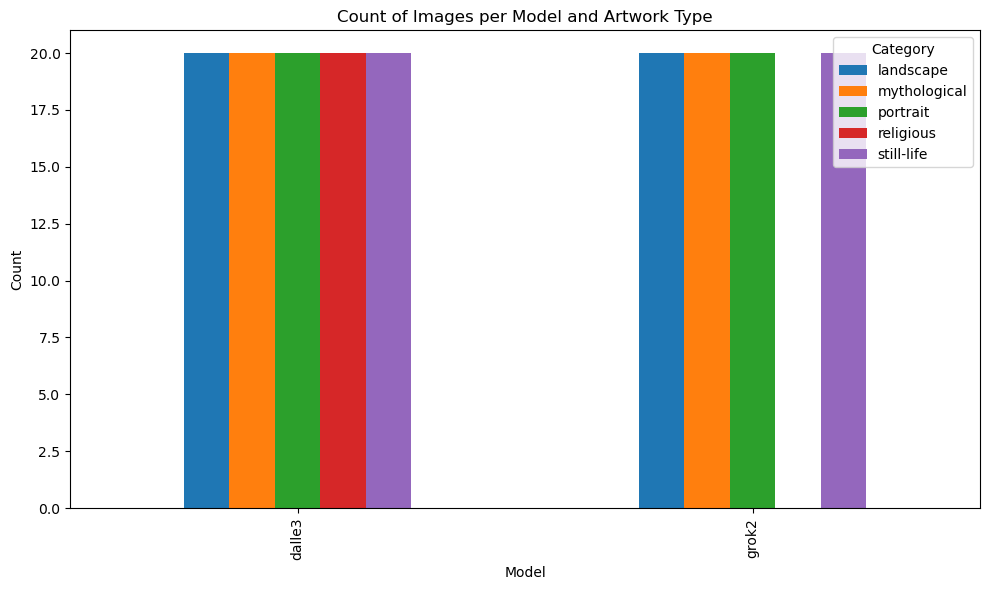

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_3696\471740867.py:263: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda x: f"{x * 100:.0f}%")


In [18]:


# Load datasets
#train_df = pd.read_csv("SemArt/semart_train.csv", sep="\t", encoding="ISO-8859-1")
test_df = pd.read_csv("data/semart_test.csv", sep="\t", encoding="ISO-8859-1")
#val_df = pd.read_csv("SemArt/semart_val.csv", sep="\t", encoding="ISO-8859-1")

#%%

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the transformation pipeline (same as used in training)
transform_pipeline = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.CenterCrop((224, 224)),  # Resize the image to match input size
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])
 
# Define the original class labels as per the encoding
original_class_labels = ["still-life", "religious", "portrait", "mythological", "landscape"][::-1]
 
# Function to upload image, preprocess, and predict
def predict_image_with_probabilities(image_path, model, device):
    # Open the image
    image = Image.open(image_path).convert("RGB")  # Ensure it is RGB
 
    # Apply transformations
    image_tensor = transform_pipeline(image).unsqueeze(0)  # Add batch dimension
 
    # Move the image tensor to the device
    image_tensor = image_tensor.to(device)
 
    # Set model to evaluation mode
    model.eval()
 
    with torch.no_grad():
        # Pass the image through the model
        outputs = model(image_tensor)
       
        # Apply softmax to get probabilities
        probabilities = F.softmax(outputs, dim=1).cpu().numpy().squeeze()
         
    # Get the predicted label
    predicted_index = torch.argmax(outputs, dim=1).item()
    predicted_class = original_class_labels[predicted_index]
 
    if False: 
        
        # Plot the image
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f"Predicted: {predicted_class}")
        plt.axis("off")
     
        # Plot the probabilities
        plt.subplot(1, 2, 2)
        classes = [original_class_labels[i] for i in range(len(probabilities))]
        print(f"the classes are: {classes}")
        plt.barh(classes, probabilities, color="skyblue")
        plt.xlabel("Probability")
        plt.title("Class Probabilities")
        plt.tight_layout()
     
        plt.show()
 
    return predicted_class, probabilities
 

 
# Load the pre-trained model (assuming it's already trained)
model = torch.load('trainedmodels\\2025_01_15_18_31_BestModel_AugmentTristan256.pth', map_location=torch.device('cpu'))  # Load your trained model
model.to(device)  # Ensure the model is on the correct device

#%%

def process_image_folder(image_folder):
    """
    Processes a folder containing image files and extracts information into a DataFrame.

    Parameters:
    image_folder (str): Path to the folder containing image files.

    Returns:
    pd.DataFrame: A DataFrame with columns for Filename, Model, and Category.
    """
    image_data = []

    # Loop through the files in the folder
    for filename in os.listdir(image_folder):
        if filename.endswith(".jpg"):  # Check for image files
            parts = filename.split("_")
            if len(parts) >= 3:
                model_used = parts[0]  # e.g., "dalle" or "grok2"
                if model_used == 'dalle':
                    model_used = 'dalle3'
                category = parts[1]  # e.g., "landscape", "portrait"
                number = parts[2].split(".")[0]
                image_data.append({"Filename": filename, "Model": model_used, "Category": category, "Number": number})

    # Convert the data to a DataFrame for visualization
    df = pd.DataFrame(image_data)

    # Sort the DataFrame
    df["Number"] = df["Number"].astype(int)
    df = df.sort_values(by=["Model", "Category", "Number"])
    df = df.reset_index(drop=True)
    df = df.drop(columns=["Number"])

    return df

# Define the folder containing the images
image_folder = "AI_Images"

# Process the folder and extract the data into a DataFrame
df = process_image_folder(image_folder)

#%% Create a histogram to show the amount of generated photos 

def plot_image_histogram(df, group_columns=["Model", "Category"], figsize=(10, 6)):
    """
    Creates and plots a histogram of image counts grouped by specified columns.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the data.
    group_columns (list): The columns to group by for the histogram (default: ["Model", "Category"]).
    figsize (tuple): The size of the plot (default: (10, 6)).

    Returns:
    None
    """
    # Create a histogram
    histogram = df.groupby(group_columns).size().unstack(fill_value=0)

    # Plot the histogram
    histogram.plot(kind="bar", stacked=False, figsize=figsize)
    plt.title("Count of Images per Model and Artwork Type")
    plt.xlabel(group_columns[0])
    plt.ylabel("Count")
    plt.legend(title=group_columns[1], loc="upper right")
    plt.tight_layout()
    plt.show()
    
plot_image_histogram(df)

#%% Add new rows to the df from the test_df

# Define relevant timeframes and types
relevant_timeframes = ['1401-1450', '1451-1500', '1501-1550', '1551-1600', '1601-1650', '1651-1700', '1701-1750', '1751-1800', '1801-1850', '1851-1900']
relevant_types = ['religious', 'landscape', 'portrait', 'mythological', 'still-life']

# Filter each dataset and reassign them
test_df = test_df[test_df["TIMEFRAME"].isin(relevant_timeframes) & test_df["TYPE"].isin(relevant_types)]

# Extract the desired columns and rename them
new_rows = test_df[["IMAGE_FILE", "TYPE"]].rename(columns={
    "IMAGE_FILE": "Filename",
    "TYPE": "Category"
})

# Add a new column for 'Model'
new_rows["Model"] = "original"

# Concatenate the new rows to the original df
df = pd.concat([df, new_rows], ignore_index=True)

#%% Get all the predictions

predictions = {}

for i, row in df.iterrows():
    
    model_used = row["Model"]
    if model_used == 'original':
        folder_path = "processed_imagesV2/"
        
    else:
        folder_path = "AI_Images/"
        
    image_path = folder_path + row["Filename"]
    
    # Run the prediction on the uploaded image
    predicted_class, probabilities = predict_image_with_probabilities(image_path, model, device)
    
    p_landscape = probabilities[0]
    p_mythological = probabilities[1]
    p_portrait = probabilities[2]
    p_religious = probabilities[3]
    p_stilllife = probabilities[4]
    
    predictions[row["Filename"]] = {"landscape": p_landscape, 
                                    "mythological": p_mythological,
                                    "portrait": p_portrait,
                                    "religious": p_religious,
                                    "still-life": p_stilllife}
    
    
    # Convert dictionary to DataFrame
    predictions_df = pd.DataFrame.from_dict(predictions, orient="index")
    predictions_df.index.name = "Filename"
    predictions_df.reset_index(inplace=True)

# Merge the original DataFrame with the new one
df = df.merge(predictions_df, on="Filename", how="left")

# Find the predicted column (column with the highest float value)
prediction_columns = ["landscape", "mythological", "portrait", "religious", "still-life"]
df["predicted"] = df[prediction_columns].idxmax(axis=1)

# Create the 'correct' column
df["correct"] = (df["predicted"] == df["Category"]).astype(int)

df.to_excel("predictions.xlsx", index=False)

 #%% Get image counts

def calculate_image_count(df, filename_column="Filename", group_columns=["Model", "Category"]):
    """
    Calculates the image count table grouped by specified columns, with totals for each group and overall.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the data.
    filename_column (str): The name of the column containing the filenames to count.
    group_columns (list): The list of columns to group by.

    Returns:
    pd.DataFrame: A DataFrame with the image count summary table.
    """
    # Group by specified columns and count the number of images
    image_count = (
        df.groupby(group_columns)[filename_column]
        .count()
        .unstack(fill_value=0)
    )

    # Add total images per Model and Category
    image_count["Total"] = image_count.sum(axis=1)
    image_count.loc["Total"] = image_count.sum()

    return image_count

image_count = calculate_image_count(df)

#%% Get accuracy table

def calculate_accuracy_summary(df, correct_column="correct", group_columns=["Model", "Category"]):
    """
    Calculates the accuracy summary table grouped by specified columns, with totals for each group and overall.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the data.
    correct_column (str): The name of the column containing boolean or numerical accuracy (1 for correct, 0 for incorrect).
    group_columns (list): The list of columns to group by.

    Returns:
    pd.DataFrame: A DataFrame with the accuracy summary table.
    """
    # Group by specified columns and calculate accuracy
    accuracy = (
        df.groupby(group_columns)[correct_column]
        .mean()
        .unstack(fill_value=0)
        .applymap(lambda x: f"{x * 100:.0f}%")
    )

    # Calculate total accuracy per Model and Category
    accuracy["Total"] = (
        df.groupby(group_columns[0])[correct_column]
        .mean()
        .apply(lambda x: f"{x * 100:.0f}%")
    )
    
    accuracy.loc["Total"] = (
        df.groupby(group_columns[1])[correct_column]
        .mean()
        .apply(lambda x: f"{x * 100:.0f}%")
    )

    accuracy.loc["Total", "Total"] = f"{df[correct_column].mean() * 100:.0f}%"

    return accuracy

accuracy_summary = calculate_accuracy_summary(df)

#%% Get more detailed accuracy table for one specific type

def calculate_category_guess_distribution(df, painting_type):
    """
    Calculates the percentage distribution of guesses across categories for a specific painting type.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the data.
    painting_type (str): The original category of paintings to analyze (e.g., "landscape").

    Returns:
    pd.DataFrame: A DataFrame where rows represent models and columns represent guessed categories,
                  with values showing the percentage of guesses.
    """
    # Filter the DataFrame for the specific painting type
    filtered_df = df[df["Category"] == painting_type]

    # Calculate the count of guesses per Model and Guessed Category
    guess_distribution = (
        filtered_df.groupby(["Model", "predicted"])["Filename"]
        .count()
        .unstack(fill_value=0)
    )

    # Normalize by row to calculate percentages
    guess_distribution = guess_distribution.div(guess_distribution.sum(axis=1), axis=0) * 100

    return guess_distribution

mythological_guess_distribution  = calculate_category_guess_distribution(df, "mythological")
